In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import layers, Sequential
from keras.utils import to_categorical
from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.1, random_state=95)
#Dataset is composed of 50000 images with 10 classes (img are 32*32*3)

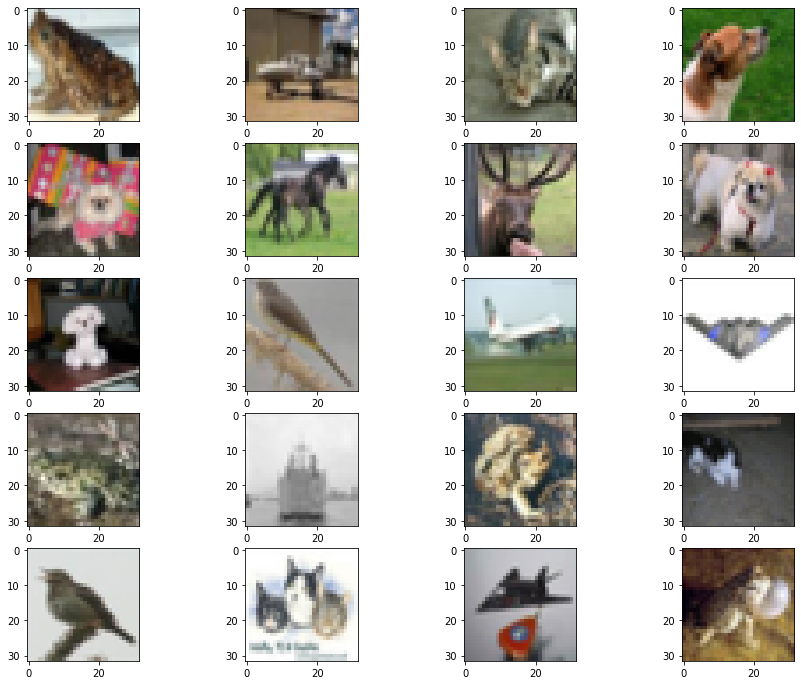

In [3]:
fig=plt.figure(figsize=(15, 12))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = x_train[i][:,:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()
#Let's display a few images from our dataset 

In [4]:
y_train = to_categorical(y_train, num_classes = 10)
y_valid = to_categorical(y_valid, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)
#transforming our labels in a correct format to plug them into the model

In [5]:
nb_classes = 10 #10 classes in the cifar10 dataset
batch_size = 64 #Batch size is classic (depends on the config you will be running the model on)
img_size = 32
nb_epochs = 50 
#Defining some of the basic hyperparameters of our model 

In [6]:
train_datagen=ImageDataGenerator(rescale=1./255, #Putting all brightness numbers between 0 & 1 
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3
    ) #Configuring the options of our Img generator (Flipping, zoom, shift)

train_generator=train_datagen.flow( #flow function apply our Data generator to our dataset
    x_train,
    y=y_train,
    batch_size=batch_size,
    shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255) #No transformation used on the test dataset we want to predict on real images

valid_generator=test_datagen.flow(
    x_valid,
    y_valid,
    batch_size=batch_size,
    shuffle=True)

In [7]:
def small_vgg(lr=0.1,decay = 0.0,activ = 'sigmoid',nb_class = 2): #Model is initialized for binary classification
    model = Sequential() #A cell is composed of 2 Conv layer with relu activation and batch norm followed by max pooling
    model.add(layers.Conv2D(input_shape = (img_size, img_size, 3), 
                     filters = 64,
                     kernel_size = (3,3),
                     padding = 'same',
                     strides = 1))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters = 64,
                            kernel_size = (3,3),
                            padding = 'same',
                            strides = 1))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size = (2,2),strides = (2,2)))
    model.add(layers.Conv2D(filters = 128, 
                     kernel_size = (3,3),
                     padding = 'same',
                     strides = 1))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters = 128,
                            kernel_size = (3,3),
                            padding = 'same',
                            strides = 1))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size = (2,2),strides = (2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nb_class, activation = activ))
    
    rmsprop = optimizers.rmsprop(lr=lr,decay = decay)
    model.compile(optimizer = rmsprop,
                  loss = 'categorical_crossentropy',
                  metrics =['accuracy'])
    return model

In [8]:
model = small_vgg(lr = 0.0001, decay = 0.0,activ= 'softmax',nb_class = nb_classes)
filepath="cifar10.0-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max',save_weights_only=False)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
callbacks_list = [checkpoint]
#training
hist = model.fit_generator(generator=train_generator,                   
                                steps_per_epoch=y_train.shape[0]/batch_size,
                                validation_data=valid_generator,                    
                                validation_steps=y_valid.shape[0]/batch_size,
                                epochs=nb_epochs,
                                callbacks = callbacks_list,
                                verbose = 2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 16s - loss: 1.8077 - acc: 0.3837 - val_loss: 1.6401 - val_acc: 0.4392

Epoch 00001: val_acc improved from -inf to 0.43920, saving model to cifar10.0-01-0.44.hdf5
Epoch 2/50
 - 13s - loss: 1.4754 - acc: 0.4725 - val_loss: 1.6126 - val_acc: 0.4580

Epoch 00002: val_acc improved from 0.43920 to 0.45800, saving model to cifar10.0-02-0.46.hdf5
Epoch 3/50
 - 13s - loss: 1.3516 - acc: 0.5181 - val_loss: 1.3173 - val_acc: 0.5476

Epoch 00003: val_acc improved from 0.45800 to 0.54760, saving model to cifar10.0-03-0.55.hdf5
Epoch 4/50
 - 13s - loss: 1.2636 - acc: 0.5489 - val_loss: 1.2779 - val_acc: 0.5630

Epoch 00004: val_acc improved from 0.54760 to 0.56300, saving model to cifar10.0-04-0.56.hdf5
Epoch 5/50
 - 13s - loss: 1.1893 - acc: 0.5784 - val_loss: 1.2445 - val_acc: 0.5732

Epoch 00005: val_acc improved from 0.56300 to 0.57320, saving model to cifar10.0-0

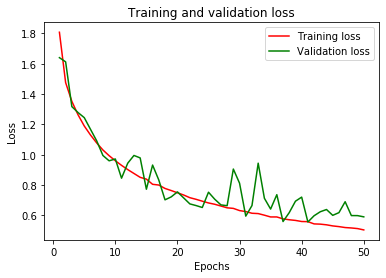

In [9]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

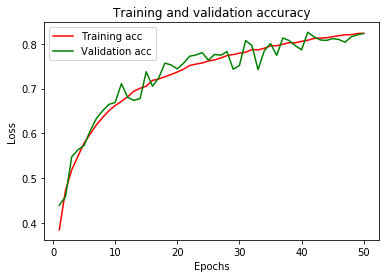

In [10]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test.astype('float32')/255) #Reshape x_test pixel values to be in the 0-1 interval like in training
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

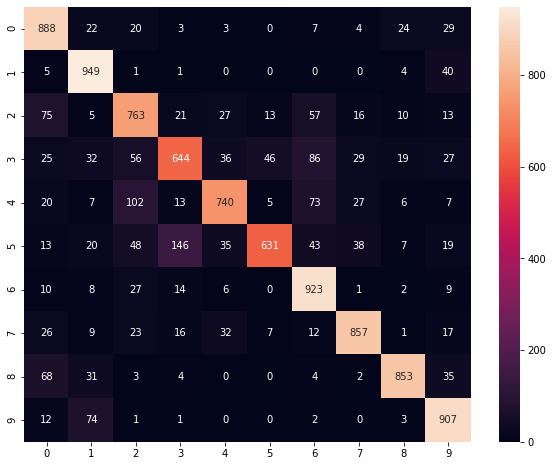

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [13]:
#from keras.models import load_model
#model_load = load_model('cifar10.0-15-0.81.hdf5')